# Topic Modeling

Obtained the data from Kaggle https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums.

In [1]:
from gensim import corpora, models, similarities, matutils
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from IPython.core.debugger import set_trace
from gensim.parsing.preprocessing import remove_stopwords
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import pickle

In [2]:
raw_data = pd.read_csv(r'taylor_swift_lyrics.csv',encoding='unicode_escape')

In [3]:
# group data by arist, album and track_title to join lyrics in the same song
grouped_data = raw_data.groupby(['artist','album','track_title'])['lyric'].apply(lambda x: ' '.join(x)).reset_index()

In [4]:
# tokenized my lyrics to prepare for further data processing
# nltk.download('punkt')
grouped_data['tokenized'] = grouped_data.lyric.apply(word_tokenize)

In [5]:
# lemmatize words to reduce words into their lemma 
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
grouped_data['lemmatize'] = grouped_data['tokenized'].apply(lambda x: [lemmatizer.lemmatize(lyric) for lyric in x])

In [6]:
# tag words base on their part of speech
tagged_tokens=[]
for token in grouped_data['lemmatize'].to_list():
    tagged_tokens.append(nltk.pos_tag(token))

In [7]:
# only preserve words that are verb, noun or adjective
tag_list = []
for song in tagged_tokens:
    tag_list.append([(word,tag) for word, tag in song if tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ')])


In [8]:
word_list = []
for song in tag_list:
    word_list.append([word for word, tag in song])

In [9]:
grouped_data['processed'] = [' '.join(song) for song in word_list]

In [10]:
# remove stopwords with gensim
grouped_data['processed'] = grouped_data['processed'].apply(remove_stopwords)

In [11]:
# remove stopwords a 2nd time with nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
stop = set(stopwords.words('english'))

def process(text):
    text = text.lower()
    # only preserve words that have three or more characters
    text_filt = re.findall(r'\b[a-zA-Z]{3,}\b', text)
    
    words_filt = [w for w in text_filt if w not in stop]
    return words_filt

grouped_data['dictionary'] = grouped_data['processed'].apply(process)
print(grouped_data.dictionary)

0     [people, want, love, gave, people, wan, believ...
1     [baby, got, bad, blood, know, mad, love, look,...
2     [nice, meet, incredible, thing, magic, madness...
3     [drought, worst, flower, grown, died, thirst, ...
4     [stand, ghost, shaking, rain, rain, open, door...
                            ...                        
89    [fine, live, mind, better, bein, met, week, tr...
90    [like, little, game, like, tilted, stage, role...
91    [glitter, floor, party, girls, carrying, shoe,...
92    [see, dark, eye, magician, eye, disappear, cut...
93    [nice, throwing, big, party, jump, pool, balco...
Name: dictionary, Length: 94, dtype: object


In [12]:
dictionary = corpora.Dictionary(grouped_data.dictionary)

dictionary.save('dictionary.dict')

In [13]:
dictionary = corpora.Dictionary.load('dictionary.dict')

In [14]:
# create document and term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in grouped_data.dictionary]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)


In [15]:
seed = 123
Lda = models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=6, id2word = dictionary, passes=7, random_state = seed)

In [16]:
ldamodel.print_topics()

[(0,
  '0.023*"think" + 0.019*"wan" + 0.013*"end" + 0.012*"hold" + 0.011*"game" + 0.008*"big" + 0.007*"night" + 0.007*"aah" + 0.007*"gorgeous" + 0.007*"day"'),
 (1,
  '0.052*"know" + 0.020*"time" + 0.019*"stay" + 0.019*"look" + 0.018*"love" + 0.017*"wish" + 0.011*"got" + 0.010*"better" + 0.010*"want" + 0.010*"think"'),
 (2,
  '0.017*"said" + 0.015*"know" + 0.015*"time" + 0.010*"delicate" + 0.010*"love" + 0.010*"want" + 0.009*"dress" + 0.009*"beautiful" + 0.009*"take" + 0.008*"mon"'),
 (3,
  '0.042*"shake" + 0.019*"new" + 0.018*"love" + 0.016*"gon" + 0.016*"york" + 0.014*"dancing" + 0.014*"welcome" + 0.014*"time" + 0.014*"girl" + 0.013*"hand"'),
 (4,
  '0.021*"know" + 0.021*"got" + 0.018*"baby" + 0.014*"thing" + 0.013*"bad" + 0.013*"feel" + 0.013*"tell" + 0.013*"come" + 0.012*"night" + 0.012*"said"'),
 (5,
  '0.026*"ooh" + 0.021*"want" + 0.021*"wood" + 0.020*"clear" + 0.017*"time" + 0.013*"trouble" + 0.013*"mean" + 0.013*"got" + 0.011*"waiting" + 0.010*"call"')]

In [17]:
# come up with topics based on the top words
# topic 0: big game [play game]
# topic 1: time better think [reflecting]
# topic 2: delicate love beautiful [beautiful love]
# topic 3: shake dancing [dancing]
# topic 4: bad feeling [feeling bad]
# topic 5: mean trouble [trouble]

d = corpora.Dictionary.load('dictionary.dict')
c = corpora.MmCorpus('corpus.mm')

In [18]:
def save(clf, name):
    pickle_out = open('/Users/shiehan/Desktop/kaplan stuff/project4/'+name,"wb")
    pickle.dump(clf, pickle_out)
    pickle_out.close()
    print ('Model ',name,' saved')

save(ldamodel, 'lda.pkl')

Plot the visualization for song topic clusters.

In [19]:
# create topic visualization with gensim
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda, c, d)
pyLDAvis.display(vis_data)


In [23]:
# create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1,1),stop_words='english',token_pattern='\\b[a-z][a-z][a-z]+\\b')
count_vectorizer.fit(grouped_data.processed)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[a-z][a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [24]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(grouped_data.processed).transpose()

In [25]:
# convert sparse matrix to genism corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [38]:
def load(clf_file):
    pickle_in = open(clf_file,"rb")
    clf = pickle.load(pickle_in)
    return clf

ldamodel = load('lda.pkl')

In [39]:
# tranform doc from word space to the topic space (like transform in sklearn)
lda_corpus = ldamodel[corpus]

In [40]:
lda_docs = [doc for doc in lda_corpus]

In [41]:
lda_docs

[[(4, 0.9915298)],
 [(3, 0.9954874)],
 [(2, 0.9956963)],
 [(0, 0.99186033)],
 [(4, 0.9919357)],
 [(2, 0.9930164)],
 [(5, 0.9948435)],
 [(2, 0.9942207)],
 [(4, 0.99453217)],
 [(3, 0.9967079)],
 [(2, 0.9937828)],
 [(2, 0.9924985)],
 [(3, 0.8504105), (4, 0.14528866)],
 [(1, 0.9944853)],
 [(4, 0.27580968), (5, 0.71945083)],
 [(2, 0.9937775)],
 [(0, 0.43352917), (2, 0.21014458), (3, 0.07209686), (4, 0.27968693)],
 [(4, 0.99034303)],
 [(2, 0.99191254)],
 [(4, 0.9926787)],
 [(5, 0.9925042)],
 [(4, 0.9935967)],
 [(0, 0.8851356), (2, 0.10916184)],
 [(2, 0.99141806)],
 [(2, 0.99347425)],
 [(5, 0.9906704)],
 [(0, 0.7455682), (1, 0.18302009), (2, 0.066426046)],
 [(4, 0.99243706)],
 [(1, 0.98849607)],
 [(4, 0.992231)],
 [(0, 0.9939921)],
 [(1, 0.9929895)],
 [(2, 0.11552665), (4, 0.8251878), (5, 0.05333515)],
 [(4, 0.9950392)],
 [(3, 0.9936936)],
 [(4, 0.991335)],
 [(1, 0.09302216), (2, 0.8109297), (5, 0.08932306)],
 [(1, 0.9923125)],
 [(0, 0.88191354), (2, 0.11203634)],
 [(2, 0.99088466)],
 [(4, 0.

In [42]:
# extract topics from lda_docs
topic_lst = []
for lst in lda_docs:
    if len(lst) == 1:
        topic_lst.append(lst[0][0])
    else:
        topic_lst.append(max(lst, key=lambda x:x[1])[0])




In [43]:
topic_map = {'0': 'play games', '1': 'reflecting', '2': 'beautiful love', '3': 'dancing', '4': 'feeling bad', '5': 'trouble'}

In [44]:
# map topic name with track_title
grouped_data['topic'] = topic_lst
grouped_data['topic'] = grouped_data['topic'].astype(str)
grouped_data["topic"].replace(topic_map, inplace=True)

In [45]:
# count the number of songs in each topic and album
topic_album = grouped_data.groupby(['album','topic'])['lyric'].count().reset_index()

In [46]:
topic_album = topic_album.rename(columns = {'lyric':'song_count'})

In [47]:
year_topic = topic_album.merge(raw_data[['album','year']].drop_duplicates(), left_on = 'album', right_on ='album' )

Analyze trends for song topics over the year.

Text(0.5, 1.0, 'Song Topics over the Years')

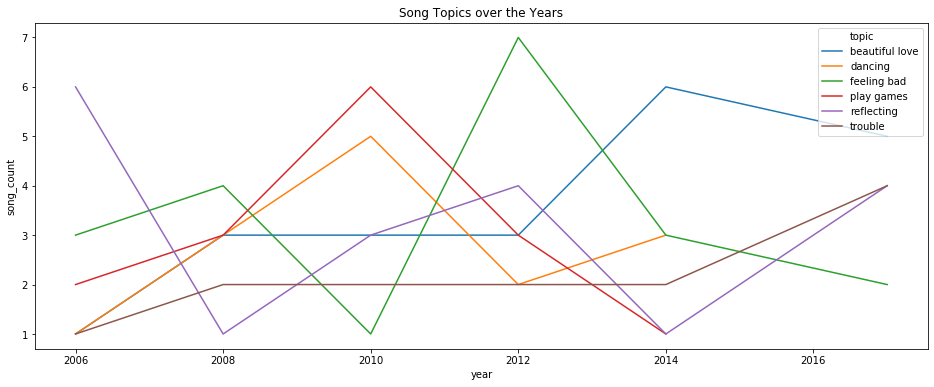

In [48]:
# plot song topics over the years graph
plt.figure(figsize=(16, 6))
sns.lineplot(x="year", y="song_count", hue="topic",data=year_topic)
plt.title('Song Topics over the Years')

In [50]:
def save(clf, name):
    pickle_out = open(name,"wb")
    pickle.dump(clf, pickle_out)
    pickle_out.close()
    print ('Model ',name,' saved')

save(grouped_data,'song_topic.pkl')

In [52]:
# top 30 hit songs from Billboard
top_30_lst = ['Shake It Off','You Belong With Me','Blank Space','Love Story','I Knew You Were Trouble','We Are Never Ever Getting Back Together','Bad Blood','Wildest Dreams'
              ,'Style','Look What You Made Me Do','Mine','Teardrops On My Guitar','Our Song','Delicate','Back To December'
             ,'White Horse','...Ready for It?','22','Fifteen','Mean','Ours','Red','Tim McGraw',"Everything Has Changed (Ft.\xa0Ed\xa0Sheeran)",
             "Should've Said No",'Picture To Burn','Begin Again','Sparks Fly','Fearless',"End Game (Ft.\xa0Ed\xa0Sheeran & Future)"]

hit_data = grouped_data[grouped_data['track_title'].isin(top_30_lst)].groupby(['topic']).agg({'artist':'count'})

In [53]:
hit_data = hit_data.reset_index().rename(columns={"artist": "count"})

In [54]:
hit_data

,topic,count
0,beautiful love,6
1,dancing,5
2,feeling bad,4
3,play games,6
4,reflecting,7
5,trouble,2


Plot the graph for Billboard Top 30 over Topics.

Text(0.5, 1.0, 'Billboard Top 30 over Topics')

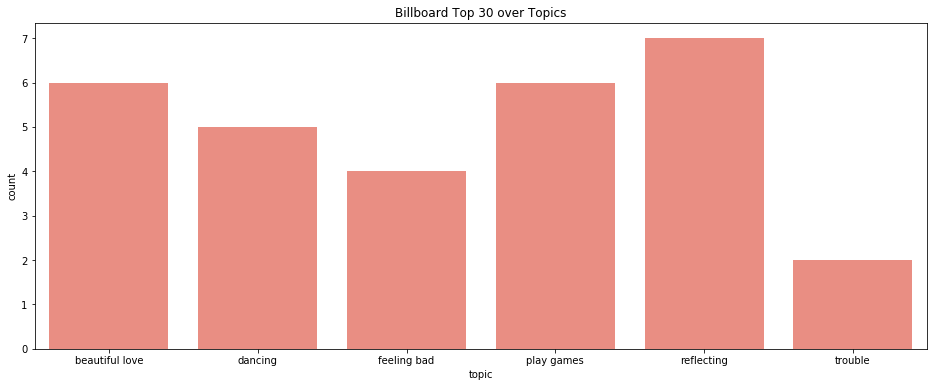

In [55]:
plt.figure(figsize=(16, 6))
sns.barplot(x='topic', y='count',data=hit_data, color='salmon')
plt.title('Billboard Top 30 over Topics')